# Load the dataset

In [1]:
# Import libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_datasets as tfds

In [2]:
# Load the MNIST dataset and display the shapes of the data
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Show the shape of the training and test data
print(f"Train shape: X_train = {X_train.shape}, y_train = {y_train.shape}")
print(f"Test shape: X_test = {X_test.shape}, y_test = {y_test.shape}")

Train shape: X_train = (60000, 28, 28), y_train = (60000,)
Test shape: X_test = (10000, 28, 28), y_test = (10000,)


# Process, normalize, and resize the images

In [3]:
# Normalize data to the value range [0,1]
X_train, X_test = X_train / 255.0, X_test / 255.0

In [4]:
# Split train/valid from the training set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=5)

# Show shape of the training, validation, and test data
print(f"Train shape: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation shape: {X_val.shape}, y_val: {y_val.shape}")
print(f"Test shape: {X_test.shape}, y_test: {y_test.shape}")

Train shape: (54000, 28, 28), y_train: (54000,)
Validation shape: (6000, 28, 28), y_val: (6000,)
Test shape: (10000, 28, 28), y_test: (10000,)


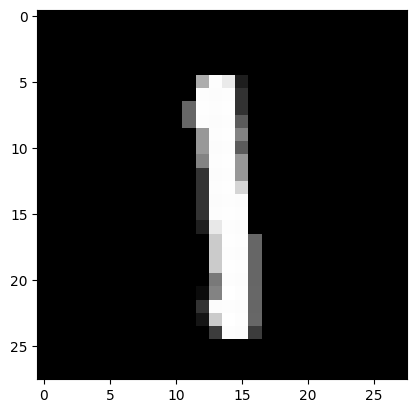

In [5]:
# Show an image
plt.imshow(X_train[0,:,:], cmap='gray')
plt.show()

In [6]:
# Generator function to resize images using OpenCV
def resize_image(X, y, batch_size, target_size = (56, 56)):
    while True:
        indices = np.random.permutation(len(X))  # Shuffle data
        for start in range(0, len(X), batch_size):
            end = min(start + batch_size, len(X))
            batch_X = []
            batch_y = []
            for i in indices[start:end]:
                # Resize each image using OpenCV and convert to RGB
                img_resized = cv2.resize(cv2.cvtColor(X[i].astype('uint8'), cv2.COLOR_GRAY2RGB), target_size)
                batch_X.append(img_resized)
                batch_y.append(y[i])
            yield np.array(batch_X), np.array(batch_y)

In [7]:
# Define batch size
batch_size = 256

# Create train, validation, and test generators
train_resized = resize_image(X_train, y_train, batch_size)
val_resized = resize_image(X_val, y_val, batch_size)
test_resized = resize_image(X_test, y_test, batch_size)

# Construct the Vanilla VGG16 Model (VGG16-version1)

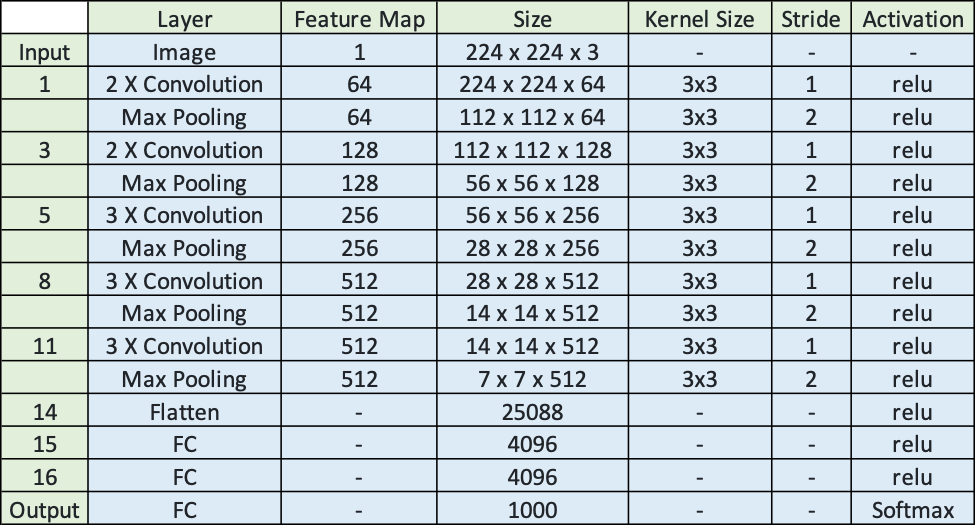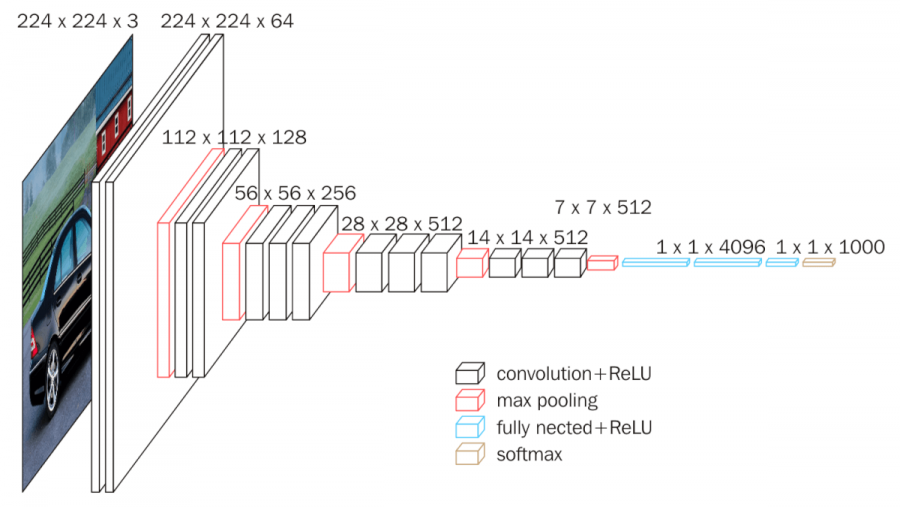

In [8]:
# Construct the VGG16 model
from tensorflow.keras import layers, models

VGG16_version1 = models.Sequential([
    # Block 1
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(56, 56, 3)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Block 2
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Block 3
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Block 4
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Block 5
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Fully connected layers
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dense(4096, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 classes for MNIST
])

optimizer = keras.optimizers.Adam(learning_rate=0.0001)

# Compile the model
VGG16_version1.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Show model summary
VGG16_version1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 56, 56, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 7, 7, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 7, 7, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 7, 7, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │       2,101,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 33,638,218 (128.32 MB)

 Trainable params: 33,638,218 (128.32 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Define the ModelCheckpoint callback to save the best model
mc = ModelCheckpoint(filepath="best_vgg16_version1.keras",
                     monitor='val_loss',
                     mode='min',
                     verbose=1,
                     save_best_only=True)

# Set steps_per_epoch and validation_steps based on dataset size and batch size
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size

In [10]:
# Train the model
history_vgg16_v1 = VGG16_version1.fit(train_resized,
                                      steps_per_epoch=steps_per_epoch,
                                      epochs=10,
                                      validation_data=val_resized,
                                      validation_steps=validation_steps,
                                      callbacks=[mc])

Epoch 1/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.2178 - loss: 2.1072
Epoch 1: val_loss improved from inf to 1.69955, saving model to best_vgg16_version1.keras
210/210 ━━━━━━━━━━━━━━━━━━━━ 105s 367ms/step - accuracy: 0.2182 - loss: 2.1064 - val_accuracy: 0.3821 - val_loss: 1.6995
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.3946 - loss: 1.6794
Epoch 2: val_loss improved from 1.69955 to 1.62806, saving model to best_vgg16_version1.keras
210/210 ━━━━━━━━━━━━━━━━━━━━ 98s 361ms/step - accuracy: 0.3946 - loss: 1.6794 - val_accuracy: 0.4126 - val_loss: 1.6281
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.4131 - loss: 1.6160
Epoch 3: val_loss improved from 1.62806 to 1.60314, saving model to best_vgg16_version1.keras
210/210 ━━━━━━━━━━━━━━━━━━━━ 64s 302ms/step - accuracy: 0.4131 - loss: 1.6160 - val_accuracy: 0.4123 - val_loss: 1.6031
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.4270 - loss: 1.5743
Epoch 4: 

# Evaluate the performance of VGG16-version1

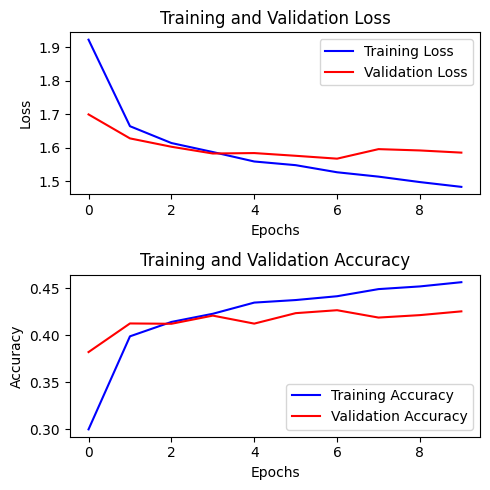

In [11]:
# Visualize training and validation performance
f, ax = plt.subplots(2, 1, figsize=(5, 5))

# Plot training and validation loss
ax[0].plot(history_vgg16_v1.history['loss'], color='b', label='Training Loss')
ax[0].plot(history_vgg16_v1.history['val_loss'], color='r', label='Validation Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot training and validation accuracy
ax[1].plot(history_vgg16_v1.history['accuracy'], color='b', label='Training Accuracy')
ax[1].plot(history_vgg16_v1.history['val_accuracy'], color='r', label='Validation Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

In [12]:
# Load a saved model and evaluate its performance on the test set
model = tf.keras.models.load_model("/content/best_vgg16_version1.keras")

# Evaluate the saved model on the test set
test_steps = int(np.ceil(len(X_test) / batch_size))
test_loss, test_acc = model.evaluate(test_resized, steps=test_steps)

# Show the model performance
print(model.metrics_names)  # Result[0] is loss, result[1] is accuracy
print(f"Test loss for VGG16-version1: {test_loss}")
print(f"Test accuracy for VGG16-version1: {test_acc}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.4332 - loss: 1.5748
['loss', 'compile_metrics']
Test loss for VGG16-version1: 1.5867633819580078
Test accuracy for VGG16-version1: 0.4287000000476837


# Normalize/resize the images for VGG16-version2

In [13]:
# Function to normalize and resize images
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`, Resizes to (56, 56, 3)."""
    image = tf.expand_dims(image, axis=-1) # Add channel dimension
    image = tf.image.resize(image, [56, 56])  # Resize to match VGG16 input size
    image = tf.image.grayscale_to_rgb(image)  # Convert grayscale to RGB
    return tf.cast(image, tf.float32) / 255., label  # Normalize

In [14]:
# Define batch size
batch_size = 256

# Apply the normalization and resizing to the training, validation, and test datasets
train_resized = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(
    normalize_and_resize_img, num_parallel_calls=tf.data.AUTOTUNE)
train_resized = train_resized.cache()
train_resized = train_resized.shuffle(len(X_train))
train_resized = train_resized.batch(batch_size)
train_resized = train_resized.prefetch(tf.data.AUTOTUNE)

val_resized = tf.data.Dataset.from_tensor_slices((X_val, y_val)).map(
    normalize_and_resize_img, num_parallel_calls=tf.data.AUTOTUNE)
val_resized = val_resized.cache()
val_resized = val_resized.batch(batch_size)
val_resized = val_resized.prefetch(tf.data.AUTOTUNE)

test_resized = tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(
    normalize_and_resize_img, num_parallel_calls=tf.data.AUTOTUNE)
test_resized = test_resized.cache()
test_resized = test_resized.batch(batch_size)
test_resized = test_resized.prefetch(tf.data.AUTOTUNE)

# Enhance the VGG16 model (VGG16-version2)

In [15]:
# Construct the VGG16 model
from tensorflow.keras import layers, models

# Enhanced VGG16 model with Batch Normalization and Dropout
VGG16_version2 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(56, 56, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 classes for MNIST
])

# Compile the model
VGG16_version2.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),  # Adjust learning rate
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

# Show model summary
VGG16_version2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)                   │ (None, 54, 54, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 27, 27, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 25, 25, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 10, 10, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 504,266 (1.92 MB)

 Trainable params: 504,266 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Define the ModelCheckpoint callback to save the best model
mc_v2 = ModelCheckpoint(filepath="best_vgg16_version2.keras",
                        monitor='val_loss',
                        mode='min',
                        verbose=1,
                        save_best_only=True)

# Set steps_per_epoch and validation_steps based on dataset size and batch size
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size

In [17]:
# Train the model
history_vgg16_v2 = VGG16_version2.fit(train_resized,
                                      steps_per_epoch=steps_per_epoch,
                                      epochs=10,
                                      validation_data=val_resized,
                                      validation_steps=validation_steps,
                                      callbacks=[mc_v2])

Epoch 1/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.1595 - sparse_categorical_accuracy: 0.3123
Epoch 1: val_loss improved from inf to 0.67689, saving model to best_vgg16_version2.keras
210/210 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 2.1576 - sparse_categorical_accuracy: 0.3132 - val_loss: 0.6769 - val_sparse_categorical_accuracy: 0.8093
Epoch 2/10
  1/210 ━━━━━━━━━━━━━━━━━━━━ 7:25 2s/step - loss: 0.7544 - sparse_categorical_accuracy: 0.7792

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 0.67689 to 0.60771, saving model to best_vgg16_version2.keras
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7544 - sparse_categorical_accuracy: 0.7792 - val_loss: 0.6077 - val_sparse_categorical_accuracy: 0.8571
Epoch 3/10
209/210 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5658 - sparse_categorical_accuracy: 0.8353
Epoch 3: val_loss improved from 0.60771 to 0.39956, saving model to best_vgg16_version2.keras
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.5651 - sparse_categorical_accuracy: 0.8355 - val_loss: 0.3996 - val_sparse_categorical_accuracy: 0.8769
Epoch 4/10
  1/210 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.3822 - sparse_categorical_accuracy: 0.9083
Epoch 4: val_loss improved from 0.39956 to 0.29909, saving model to best_vgg16_version2.keras
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3822 - sparse_categorical_accuracy: 0.9083 - val_loss: 0.2991 - val_sparse_categorical_accuracy: 0.9018
Epoch 5/10
208/210 ━━━━━━━━━━━━━━━━━━━━

# Evaluate the performance of VGG16-version2

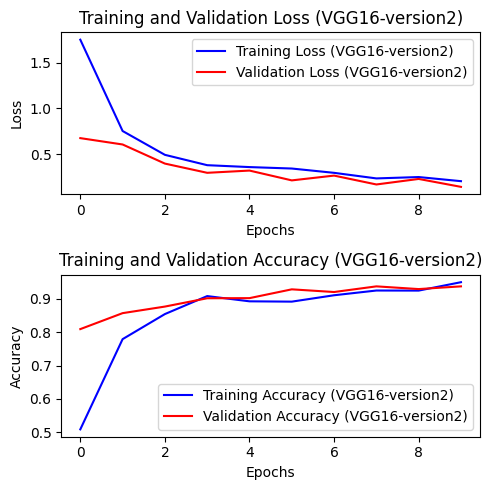

In [18]:
# Visualize the training process
f, ax = plt.subplots(2, 1, figsize=(5, 5))

# Plot training and validation loss for VGG16-version2
ax[0].plot(history_vgg16_v2.history['loss'], color='b', label='Training Loss (VGG16-version2)')
ax[0].plot(history_vgg16_v2.history['val_loss'], color='r', label='Validation Loss (VGG16-version2)')
ax[0].set_title('Training and Validation Loss (VGG16-version2)')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot training and validation accuracy for VGG16-version2
ax[1].plot(history_vgg16_v2.history['sparse_categorical_accuracy'], color='b', label='Training Accuracy (VGG16-version2)') # Changed 'accuracy' to 'sparse_categorical_accuracy'
ax[1].plot(history_vgg16_v2.history['val_sparse_categorical_accuracy'], color='r', label='Validation Accuracy (VGG16-version2)') # Changed 'val_accuracy' to 'val_sparse_categorical_accuracy'
ax[1].set_title('Training and Validation Accuracy (VGG16-version2)')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

In [19]:
# Load the saved enhanced model (VGG16-version2)
model_v2 = tf.keras.models.load_model("/content/best_vgg16_version2.keras")

# Evaluate the saved enhanced model on the test set
test_steps = int(np.ceil(len(X_test) / batch_size))
test_loss_v2, test_acc_v2 = model_v2.evaluate(test_resized, steps=test_steps)

# Display the test performance of the enhanced model
print(model_v2.metrics_names)
print(f"Test loss for VGG16-version2: {test_loss_v2}")
print(f"Test accuracy for VGG16-version2: {test_acc_v2}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.2538 - sparse_categorical_accuracy: 0.9225
['loss', 'compile_metrics']
Test loss for VGG16-version2: 0.21987509727478027
Test accuracy for VGG16-version2: 0.9351999759674072


# Comments and observations on the model’s effectiveness

VGG16-version 1 model

*   Architecture: This model follows the traditional VGG16 architecture but adapted for smaller images (56x56 instead of 224x224).
*   Performance: This model starts with lower accuracy, and the progression in training shows modest improvements. The model achieves a final test accuracy of approximately 42.87%, which is relatively low. This indicates potential issues such as overfitting given the complexity of the model relative to the simplicity of the dataset.
*   Training Dynamics: The model’s loss decreases slowly, and the accuracy improvements are incremental. This suggests that the model might be too complex for the dataset, resulting in inefficient learning and potential overfitting.

VGG16-version 2 model

*   Architecture: The model simplifies the architecture by reducing the number of filters in the convolutional layers and does not replicate the full depth of the original VGG16. This makes the network less complex and potentially more suited for a dataset like MNIST.
*   Performance: This model demonstrates significantly better performance, with a final test accuracy of about 93.52%. The substantial increase in performance indicates that the simplifications and adjustments made, including normalization and dropout, have effectively addressed the overfitting and complexity issues present in the first model.
*   Training Dynamics: The training and validation losses decrease more rapidly and consistently compared to the first model. The improved loss metrics and higher accuracy on validation and test sets indicate a better fit of the model to the data.